# Pseudocode zur Implementierung

In [14]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os
from IPython.display import display, HTML

In [15]:
# dieser Test-df wird von Christophs Programm erzeugt.
# wichtig!!! Bei der Besprechung müssen wir P_delta als NaN Value in den Datenframe einfügen

#Event dataframe anlegen zur späteren Auswertung der An/Abschaltevents
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                   'Ladevorgang', 'Status', 'Ladeleistung',
                                   'minuten_index_Abschaltung','timestamp_abschalt'])
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])

Leerlaufleistung_Phase = 0

## Funktion
-------

In [16]:
def add_p_delta(df):
    df_length = len(df)
    index_last_row = df_length - 1
    if(df_length > 1):
        p_new = df.iloc[index_last_row]['P']
        p_old = df.iloc[index_last_row-1]['P']
        p_delta = p_new - p_old
        return p_delta
    else:
        return 0

In [20]:
def detect_switch_event(rows, phase, Event_df):
    minuten_index = rows.index[-1]
    timestamp = rows.iloc[-1]['timestamp']
    Leerlaufleistung_Phase = dict[phase].iloc[0]['P']  
    ### Einschaltvorgang dedektieren ###
    # ist delta P relevant
    if(rows.iloc[-1]['P_delta'] > 200):
        # Prüfen ob Ladenvorgang beginnt/beendet
        # Wenn delta P positiv ---> event kreieren um später zu checken ob es ein Einschaltvorgang war
        Event_df.loc[len(Event_df)]= [timestamp, phase, minuten_index, 'ein', 'not checked', 0,0,0]
    
    #Check events: Überprüfen ob vorher eingetragenes event wirklich ein Einschaltvorgang ist
    event_df_length = len(Event_df)
    row_event = 0
    while row_event < event_df_length:
            #condition to check event
            minuten_index_event = Event_df.iloc[row_event]['minuten_index']
            #Check auf Einschaltvorgang
            if ((minuten_index_event+3 == minuten_index) & 
                (Event_df.iloc[row_event]['Ladevorgang'] == 'ein') &
                (Event_df.iloc[row_event]['Phase'] == phase)):
                Ladeleistung = rows.loc[minuten_index_event+3]['P'] - rows.loc[minuten_index_event-3]['P']            
                sum_delta_P = rows.loc[minuten_index_event:minuten_index_event+3]['P_delta'].sum()
                deviation = abs(Ladeleistung-sum_delta_P)/Ladeleistung 
                
                #print('deviation: {}'.format(deviation))
                print('Ladeleistung: {}'.format(Ladeleistung))
                #print('minute: {}'.format(minuten_index_event))
                
                #Kein Einschaltvorgang:
                if ((deviation > 0.07) | (Ladeleistung < 1000)):
                    Event_df = Event_df.drop(row_event)
                    Event_df = Event_df.reset_index(drop=True)
                #Einschaltvorgang
                else:
                    #Mehrere Einschaltungen gleichzeitig
                    num_cars = Ladeleistung//3000
                    if (num_cars>=2):
                        Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', (Ladeleistung/num_cars)]
                        for num_cars in range (2,int(Ladeleistung//3000)+1):
                            Event_df.loc[row_event+1]= [timestamp, phase, minuten_index_event, 'ein', 'not checked', 0,0,0]
                            Event_df.loc[row_event+1, ['Status', 'Ladeleistung']] = ['checked', (Ladeleistung/num_cars)]
                            row_event += 1
                    #Ein Einschaltvorgang
                    else:
                        Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', Ladeleistung]
            event_df_length = len(Event_df)
            row_event += 1
         
    ### Ausschaltvorgang dedektieren ###
    #Checken ob aktuelle Leistung das Ende eines Einschaltvorgangs impliziert        
    if (('ein' in Event_df['Ladevorgang'].unique()) &
        ('checked' in Event_df['Status'].unique())):
        # create df with charging status on
        only_load_event_df = Event_df[(Event_df['Ladevorgang'] == 'ein') &
                                      (Event_df['minuten_index'] < minuten_index)&
                                      (Event_df['Phase'] == phase)]
        # Soll Leistung = Leistung die auf der Phase anliegen sollte,
        # wenn alle zuvor ladenden Autos noch an der Phase hängen würden
        
        Soll_Leistung = Leerlaufleistung_Phase + Event_df[(Event_df['Ladevorgang']=='ein') & 
                                                          (Event_df['minuten_index'] <= minuten_index) & 
                                                          (Event_df['minuten_index_Abschaltung'] == 0) & 
                                                          (Event_df['Phase'] == phase)]['Ladeleistung'].sum()
        #Aktuelle Leistung (neuer Messwert)
        Ist_Leistung = rows.iloc[-1]['P']
        #Residuale Leistung 
        P_residual = Soll_Leistung - Ist_Leistung
        #Überprüfen ob fehlende Leistung (P_residual) zu einem zuvor ladenden Auto passt
        only_load_event_df['deviation_P'] = only_load_event_df['Ladeleistung']. \
                                    apply(lambda ladeleistung_auto: abs(ladeleistung_auto-P_residual)/ladeleistung_auto)

        if ((only_load_event_df['deviation_P'] < 0.2).any()):
            # sort load events by size
            # und nehme das erste Event, was der aktuellen leistung am nächsten ist
            charg_off_ev_index = only_load_event_df['deviation_P'].sort_values().index[0]
            Event_df.loc[charg_off_ev_index,['minuten_index_Abschaltung']] = minuten_index
            Event_df.loc[charg_off_ev_index,['timestamp_abschalt']] = timestamp
            Event_df.loc[charg_off_ev_index, ['Ladevorgang']] = 'aus'
            
    return Event_df

In [18]:
def combine_charging_events(Event_df):
    # Zusammenfassen von mehrphasigen Ladevorängen
    for events in range(0,len(Event_df)):
        timestamp = Event_df.iloc[events]['timestamp']
        timestamp_abschaltung = Event_df.iloc[events]['timestamp_abschalt']
        Phase = []
        Ladeleistung = []
        same_events = Event_df.loc[Event_df['timestamp'] == Event_df.iloc[events]['timestamp']]
        event_count = len(same_events)
        for a in range (0,event_count):
            Phase.append(same_events.iloc[a]['Phase'])
            Ladeleistung.append(str(same_events.iloc[a]['Phase'])+': '+str(same_events.iloc[a]['Ladeleistung']))
        if (len(ladevorgang_df.loc[ladevorgang_df['timestamp_start'] == timestamp]) !=1):
            ladevorgang_df.loc[len(ladevorgang_df)]= [timestamp, Phase, Ladeleistung, timestamp_abschaltung]
            
    return ladevorgang_df

## Code Simulation auf dem Server
----
Hier kann der Code für eine Phase Simuliert werden

In [21]:
%%time

Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                   'Ladevorgang', 'Status', 'Ladeleistung',
                                   'minuten_index_Abschaltung','timestamp_abschalt'])
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])



#Looping over dates
for filename in os.listdir('HDF5'):
    if (filename[6:7]=='1'):
        date = filename[-13:-3]
    else:
        continue
    P_Phase_1 = pd.read_hdf('HDF5/phase_1_' + date + '.h5',columns =['P', 'timestamps'])
    P_Phase_2 = pd.read_hdf('HDF5/phase_2_' + date + '.h5',columns =['P', 'timestamps'])
    P_Phase_3 = pd.read_hdf('HDF5/phase_3_' + date + '.h5',columns =['P', 'timestamps'])
    dict = {1:P_Phase_1,2:P_Phase_2,3:P_Phase_3}
    P_Phase_1 = P_Phase_1[['P','timestamp']]
    P_Phase_2 = P_Phase_2[['P','timestamp']]
    P_Phase_3 = P_Phase_3[['P','timestamp']]
    
    P_Phase_1['P_delta'] = 0
    P_Phase_2['P_delta'] = 0
    P_Phase_3['P_delta'] = 0
    
    P_Phase_1= P_Phase_1.groupby(np.arange(len(P_Phase_1))//300).mean()
    P_Phase_2= P_Phase_2.groupby(np.arange(len(P_Phase_2))//300).mean()
    P_Phase_3= P_Phase_3.groupby(np.arange(len(P_Phase_3))//300).mean()

    pseudocode_df_1 = pd.DataFrame([])
    pseudocode_df_2 = pd.DataFrame([])
    pseudocode_df_3 = pd.DataFrame([])
    phasen_variable = 1


    for row in range(0, len(P_Phase_1)):
        #Phase 1
        
        pseudocode_df_1 = pseudocode_df_1.append(P_Phase_1[row:row+1])

        # call the function to add P-delta
        pseudocode_df_1.iloc[-1, pseudocode_df_1.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_1[-2:])

        # Detect all switch events
        Event_df = detect_switch_event(pseudocode_df_1.iloc[-7:], 1, Event_df)

        # Phase 2
        pseudocode_df_2 = pseudocode_df_2.append(P_Phase_2[row:row+1])
        pseudocode_df_2.iloc[-1, pseudocode_df_2.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_2[-2:])
        Event_df = detect_switch_event(pseudocode_df_2.iloc[-7:], 2, Event_df)

        # Phase 3
        pseudocode_df_3 = pseudocode_df_3.append(P_Phase_3[row:row+1])
        pseudocode_df_3.iloc[-1, pseudocode_df_3.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_3[-2:])
        Event_df = detect_switch_event(pseudocode_df_3.iloc[-7:], 3, Event_df)
    
    

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Ladeleistung: 3432.6427154541016
Ladeleistung: 3435.330711364746


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Ladeleistung: 3426.72900390625
Ladeleistung: 3428.1943359375
Ladeleistung: 3562.5038452148438
Ladeleistung: 3559.548080444336
Ladeleistung: 3523.51416015625
Ladeleistung: 3518.234375
Ladeleistung: 3520.35791015625
Ladeleistung: 3397.401382446289
Ladeleistung: 3398.6973571777344
Ladeleistung: 7021.274230957031
Ladeleistung: 7030.416046142578
Ladeleistung: 3486.699951171875
Ladeleistung: 3497.713134765625
Ladeleistung: 3549.897186279297
Ladeleistung: 3523.127426147461
Ladeleistung: 3430.183837890625
Ladeleistung: 3419.44677734375
Wall time: 3min 18s


In [51]:
Event_df[Event_df['Phase']==3]

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.503374e+09,3,355,aus,checked,3384.16,738,1.5034e+09
3,1.503393e+09,3,667,aus,checked,2190.55,683,1.50339e+09
4,1.503398e+09,3,757,aus,checked,3615.63,866,1.5034e+09
5,1.503424e+09,3,1189,aus,checked,3679.86,1426,1.50344e+09


In [22]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.493261e+09,3,291,aus,checked,3432.64,612,1.49328e+09
1,1.493264e+09,3,341,aus,checked,3426.73,561,1.49328e+09
2,1.493274e+09,1,493,aus,checked,3562.5,598,1.49328e+09
3,1.493280e+09,3,594,aus,checked,3523.51,857,1.4933e+09
4,1.493286e+09,3,700,aus,checked,3518.23,715,1.49329e+09
5,1.493291e+09,1,785,aus,checked,3397.4,902,1.4933e+09
6,1.493296e+09,2,868,aus,checked,3510.64,1007,1.4933e+09
7,1.493296e+09,2,868,aus,checked,3510.64,1086,1.49331e+09
8,1.493297e+09,1,878,aus,checked,3486.7,979,1.4933e+09
9,1.493297e+09,3,883,aus,checked,3549.9,1264,1.49332e+09


In [57]:
combine_charging_events(Event_df)

,timestamp_start,Phasen,Durchschnittliche Ladeleistung,Ladevorgang_ende
0,1.503374e+09,[3],[3: 3384.16256714],1.503397e+09
1,1.503393e+09,"[1, 2, 3]","[1: 2177.296875, 2: 2166.87315369, 3: 2190.553...",1.503394e+09
2,1.503398e+09,[3],[3: 3615.63038635],1.503405e+09
3,1.503424e+09,[3],[3: 3679.8585434],1.503438e+09


<IPython.core.display.Javascript object>


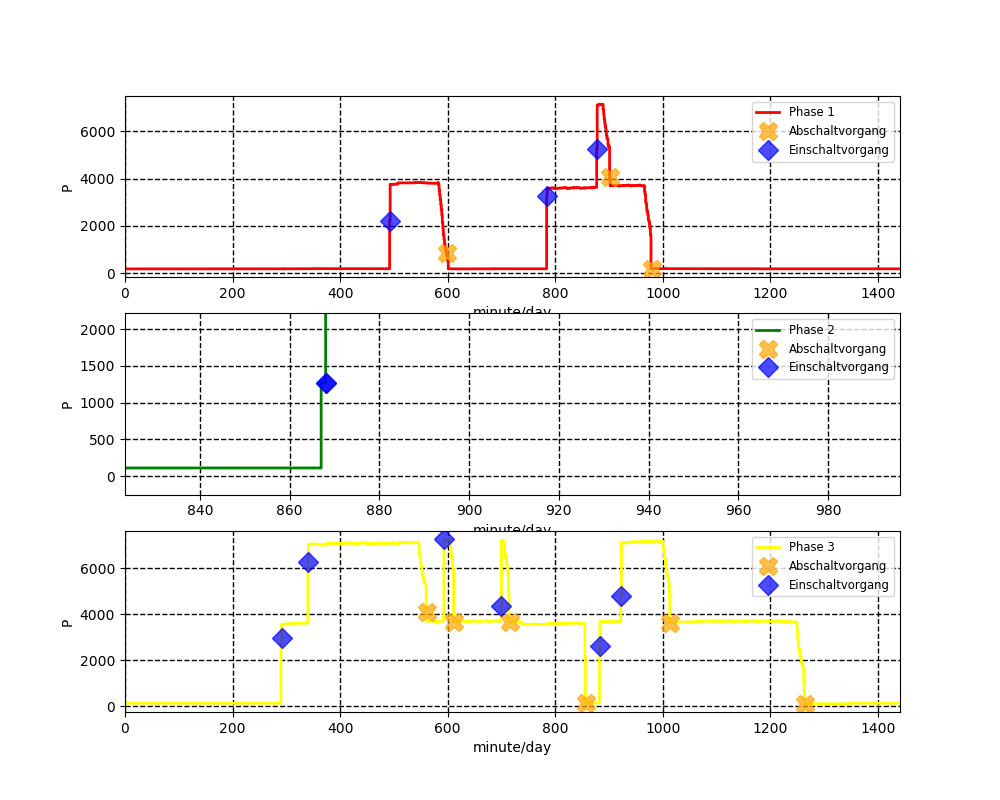

In [23]:
colors_phase = ['red','green','yellow']
#P_Phase_2 = pd.read_hdf('HDF5/phase_2_' + date + '.h5',columns =['P', 'timestamps'])
#P_Phase_2= P_Phase_2.groupby(np.arange(len(P_Phase_2))//300).mean()
dict = {1:P_Phase_1,2:P_Phase_2,3:P_Phase_3}
plt.figure(figsize=(10,8))
for Phase in range (1,4):
    Phase_P = dict[Phase]
    plt.subplot(310+Phase)
    plt.step(Phase_P.index,Phase_P['P'], color=colors_phase[Phase-1], linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung']]['P'], "X",color="orange", markersize=13,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index']]['P'], "D", color="blue", markersize=10,alpha=.7, label='Einschaltvorgang')
    plt.legend(loc='upper right', frameon=True, fontsize = 'small')
    plt.grid(color='k', linestyle='--', linewidth=1)
    plt.xlim([0,len(Phase_P)])
    plt.ylabel('P')
    plt.xlabel('minute/day')

In [54]:
pseudocode_df_1[640:680]

,P,timestamp,P_delta
640,196.232834,1.503391e+09,-0.513824
641,195.333832,1.503391e+09,-0.899002
642,195.835510,1.503391e+09,0.501678
643,194.599319,1.503391e+09,-1.236191
644,196.108383,1.503391e+09,1.509064
645,196.594193,1.503392e+09,0.485809
646,195.983749,1.503392e+09,-0.610443
647,195.859543,1.503392e+09,-0.124207
648,197.228882,1.503392e+09,1.369339
649,195.416138,1.503392e+09,-1.812744
